<a href="https://colab.research.google.com/github/AmriteshDOT/nlp_/blob/main/agenticAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
modeltype = "distilbert/distilbert-base-uncased"

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn

class regressor(nn.Module):

    def __init__(self, model_name, mlm_path=None):
        super().__init__()
        if mlm_path:
            self.model = AutoModel.from_pretrained(mlm_path)
            self.model.resize_token_embeddings(len(tokenizer))
        else:
            self.model = AutoModel.from_pretrained(model_name)
            self.model.resize_token_embeddings(len(tokenizer))

        self.fc = nn.Linear(self.model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        hidden = outputs.last_hidden_state  #blh
        pooled = hidden.mean(dim=1)  #meanPool
        return self.fc(pooled).squeeze(-1)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("/tokenizer")
model = regressor(modeltype, mlm_path=None, tokenizer=tokenizer)
state = torch.load("essay_regressor.pth", map_location="cpu")
model.load_state_dict(state)
model.to(device)
model.eval()

In [ ]:
import numpy as np

def val2grade(arr):
    scaled = np.array(arr).reshape(-1) * 5.0
    edges = [-np.inf, 0.83333333, 1.66666667, 2.5, 3.33333333, 4.16666667, np.inf]
    labels = np.digitize(scaled, edges) - 1
    labels = np.clip(labels, 0, 5)
    return (labels + 1).tolist()

In [ ]:

def preprocess(texts):
    enc = tokenizer(
        texts if isinstance(texts, list) else [texts],
        padding="max_length",
        truncation=True,
        max_length=256,
        return_tensors="pt"
    )
    return enc

In [ ]:
def predict(texts):
    enc = preprocess(texts)
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        out = model(enc["input_ids"], enc["attention_mask"]).cpu().numpy()
    grades = val2grade(out)
    return out.tolist(), grades

In [ ]:
query="Trees are life's silent guardians, purifying the air and water we need to survive. They offer shade, food, and building materials, and their roots prevent soil erosion. Observing them can be a peaceful, relaxing experience, but their role extends to climate regulation and supporting countless other species. Their importance makes it our duty to protect and plant more trees for a healthier planet. "

In [ ]:
_ , grade = predict(query)
res = grade[0]

In [ ]:
#GenAI

In [5]:
import pandas as pd
df=pd.read_csv("/content/trainn.csv")
# df=df.head()
# df.head()
# df.columns

Index(['essay_id', 'full_text', 'score'], dtype='object')

In [6]:
!pip install -qU  langchain langchain-huggingface sentence_transformers

In [7]:
from langchain_core.documents import Document

docs = []
for _, row in df.iterrows():
    docs.append(
        Document(
            page_content=row["full_text"],
            metadata={"essay_id": row["essay_id"], "essay_score": row["score"]}
        )
    )

In [8]:
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="Qwen/Qwen3-Embedding-0.6B")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import getpass
import os

os.environ["HUGGINGFACEHUB_API_TOKEN"] = userdata.get('HUGGINGFACEHUB_API_TOKEN')

In [10]:
!pip install langchain_google_genai

In [26]:
from google.colab import userdata
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.7,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [15]:
!pip install -U chromadb langchain-chroma

In [16]:
from langchain_chroma import Chroma

vectorstore = Chroma.from_documents(
    documents=docs,
    embedding=embeddings,
    persist_directory="./essay_db"
)

In [17]:
vectorstore = Chroma(
    persist_directory="./essay_db",
    embedding_function=embeddings
)

In [ ]:
# retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

# query = "How can technology improve education?"
# results = retriever.invoke(query)

# for i, doc in enumerate(results):
#     print(f"Essay {i+1} => ")
#     print(doc.metadata)
#     print(doc.page_content[:200], "...")


In [ ]:
#LangGraph

In [18]:
import os
import pandas as pd
import numpy as np
from typing import TypedDict, List, Annotated
from langgraph.graph import StateGraph, END

In [19]:
class AgentState(TypedDict):
    user_essay: str
    predicted_score: float
    retrieved_essays: List[str]
    feedback: str
    critic_report: str
    iteration: int
    feedback_status: str
    final_curated_essay: str


def diagnose_essay(state: AgentState):
    """Uses the BERT model to get the initial grade."""

    essay_input = state["user_essay"]
    _ , grade = predict(essay_input)
    score = grade[0]
    # score = 3 #mock
    return {"predicted_score": score, "iteration": 0}

def retrieve_exemplars(state: AgentState):
    """RAG: Smart semantic search that handles perfect scores."""

    user_query = state["user_essay"]
    current_score = state["predicted_score"]
    max_possible_score = 6.0

    if current_score >= max_possible_score:
        search_filter = {"essay_score": {"$eq": max_possible_score}}
    else:
        search_filter = {"essay_score": {"$gt": current_score}}

    #Search
    results = vectorstore.similarity_search(
        user_query,
        k=3,
        filter=search_filter
    )
    #Fallback
    if not results:
        results = vectorstore.similarity_search(
            user_query,
            k=2,
            filter={"essay_score": {"$gte": max_possible_score - 1}}
        )

    exemplars = [doc.page_content for doc in results]
    return {"retrieved_essays": exemplars}

def pedagogical_coach(state: AgentState):

    current_iteration = state.get("iteration", 0) + 1
    exemplar_text = "\n\n".join(state["retrieved_essays"])

    #prompt
    full_prompt = (
        f"You are an expert writing coach. Compare the 'User Essay' below "
        f"to these 'High-Scoring Exemplars'. Use the 5W1H framework to "
        f"provide specific feedback on how to improve the score from "
        f"{state['predicted_score']} to a higher level.\n\n"
        f"USER ESSAY:\n{state['user_essay']}\n\n"
        f"EXEMPLARS:\n{exemplar_text}"
    )

    response = llm.invoke(full_prompt)
    # print(type(response))
    return {
        "feedback": response.content,
        "iteration": current_iteration
    }

In [20]:
from pydantic import BaseModel, Field
from typing import Literal

class CriticSchema(BaseModel):
    reasoning: str = Field(description="Internal step-by-step analysis: Does the feedback clearly explain the 5W1H gaps based on the exemplars?")
    verdict: Literal["approved", "needs_revision"] = Field(description="Decision on whether the feedback is ready for the user.")
    missing_elements: str = Field(description="Specific list of 5W1H components or comparisons missing from the feedback.")

In [21]:
def reflection_critic(state: AgentState):

    #structureOP+CoT
    critic_llm = llm.with_structured_output(CriticSchema)

    system_prompt = """
    You are a Master Writing Critic. Your job is to audit the 'Pedagogical Coach's' feedback.

    EVALUATION CRITERIA:
    1. 5W1H Integrity: Does it identify Who, What, Where, When, Why, and How?
    2. Actionability: Is the advice specific enough for the student to rewrite their essay?
    3. Comparison: Does it explicitly reference the 'Exemplars' provided?

    INSTRUCTIONS:
    - Use the 'reasoning' field to perform a deep-dive analysis.
    - If any 5W1H element is missing, set verdict to 'needs_revision'.
    - Only 'approve' if the feedback is truly transformative.
    """
    #Invoke
    report = critic_llm.invoke([
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"USER ESSAY: {state['user_essay']}\n\nFEEDBACK TO EVALUATE: {state['feedback']}"}
    ])
    return {
        "critic_report": f"REASONING: {report.reasoning}\n\nMISSING: {report.missing_elements}",
        "feedback_status": report.verdict
    }

In [22]:
def should_continue(state: AgentState):
    #verdict
    if state.get("feedback_status") == "approved" or state["iteration"] > 1:
        return "generate_final_essay"
    else:
        return "re-generate"

In [23]:
def final_teacher_writer(state: AgentState):
    exemplar_text = "\n\n".join(state["retrieved_essays"])

    prompt = (
        f"You are a Master Professor. Based on the following student essay and the "
        f"expert feedback provided, write a 'Gold Standard' version of this essay.\n\n"
        f"STUDENT ORIGINAL:\n{state['user_essay']}\n\n"
        f"FEEDBACK TO INCORPORATE:\n{state['feedback']}\n\n"
        f"EXEMPLARS FOR STYLE REFERENCE:\n{exemplar_text}\n\n"
        f"Provide only the final curated essay without any preamble."
    )

    response = llm.invoke(prompt)
    return {"final_curated_essay": response.content}

In [24]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(AgentState)

workflow.add_node("diagnose", diagnose_essay)
workflow.add_node("retrieve", retrieve_exemplars)
workflow.add_node("coach", pedagogical_coach)
workflow.add_node("critic", reflection_critic)
workflow.add_node("final_writer", final_teacher_writer)

workflow.add_edge(START, "diagnose")
workflow.add_edge("diagnose", "retrieve")
workflow.add_edge("retrieve", "coach")
workflow.add_edge("coach", "critic")

workflow.add_conditional_edges(
    "critic",
    should_continue,
    {
        "re-generate": "coach",
        "generate_final_essay": "final_writer"
    }
)
workflow.add_edge("final_writer", END)
app = workflow.compile()

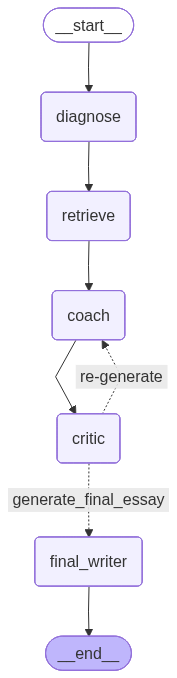

In [31]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
initial_state = {
    "user_essay": "Write your essay text here...",
    "iteration": 0
}

for output in app.stream(initial_state):
    #stream
    print(output)